# LOYALTY PROGRAM

<p style="font-family:Helvetica Neue;font-size:20px">
    This project is to create a predictive model to predict the loyalty of the customers using labeled data, a binary (two-class) classification problems.  This is a dataset with six variables, both categorical as well as continues, describing customers for a business. It has 120000 data points with variable 'loyalty' as the binary outcome. Since its good to try multiple modes I will use logistic regression and random forest, both are supervised learning models and can be used for binary classification model, easy to set up yet produces a high performance on these type of datasets.
</p>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [14]:
df = pd.read_csv('customers_data.csv').drop('Unnamed: 0', 1).dropna()
df.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,male,no,31.0,35.0,False
1,65.16,male,yes,23.0,61.0,False
2,40.60,female,no,36.0,49.0,False
3,38.01,male,yes,47.0,57.0,False
4,22.32,female,yes,5.0,39.0,False


In [15]:
# some variables are missing becasue they are not numerical values
df.describe()

,purch_amt,age,days_since_last_purch
count,120000.000000,120000.000000,120000.000000
mean,44.036234,25.803008,56.605908
std,20.473148,10.153072,16.422187
min,-43.950000,-22.000000,-9.000000
25%,30.210000,19.000000,45.000000
50%,43.970000,26.000000,57.000000
75%,57.830000,33.000000,68.000000
max,142.200000,71.000000,125.000000


In [16]:
#dummy variables for catigoriacal and non-numerical variables,
#models only accepts numbers
#don't mess with orignial dataframe therefore df2
df2 = pd.get_dummies(df)
df2.head()

,purch_amt,age,days_since_last_purch,loyalty,gender_female,gender_male,card_on_file_no,card_on_file_yes
0,19.58,31.0,35.0,False,0,1,1,0
1,65.16,23.0,61.0,False,0,1,0,1
2,40.60,36.0,49.0,False,1,0,1,0
3,38.01,47.0,57.0,False,0,1,0,1
4,22.32,5.0,39.0,False,1,0,0,1


<p style="font-family:Helvetica Neue;font-size:20px">
    Variable 'gender_female' and 'gender_male' has high correlation and variable 'card_on_file_no' and 'card_on_file_yes' also has high correlation. One of the pair variables captures the information perfectly of the other therefore only the 'gender_female' and 'card_on_file_no' will be kept. Multicollinearity creates over fitting issue.
</p>

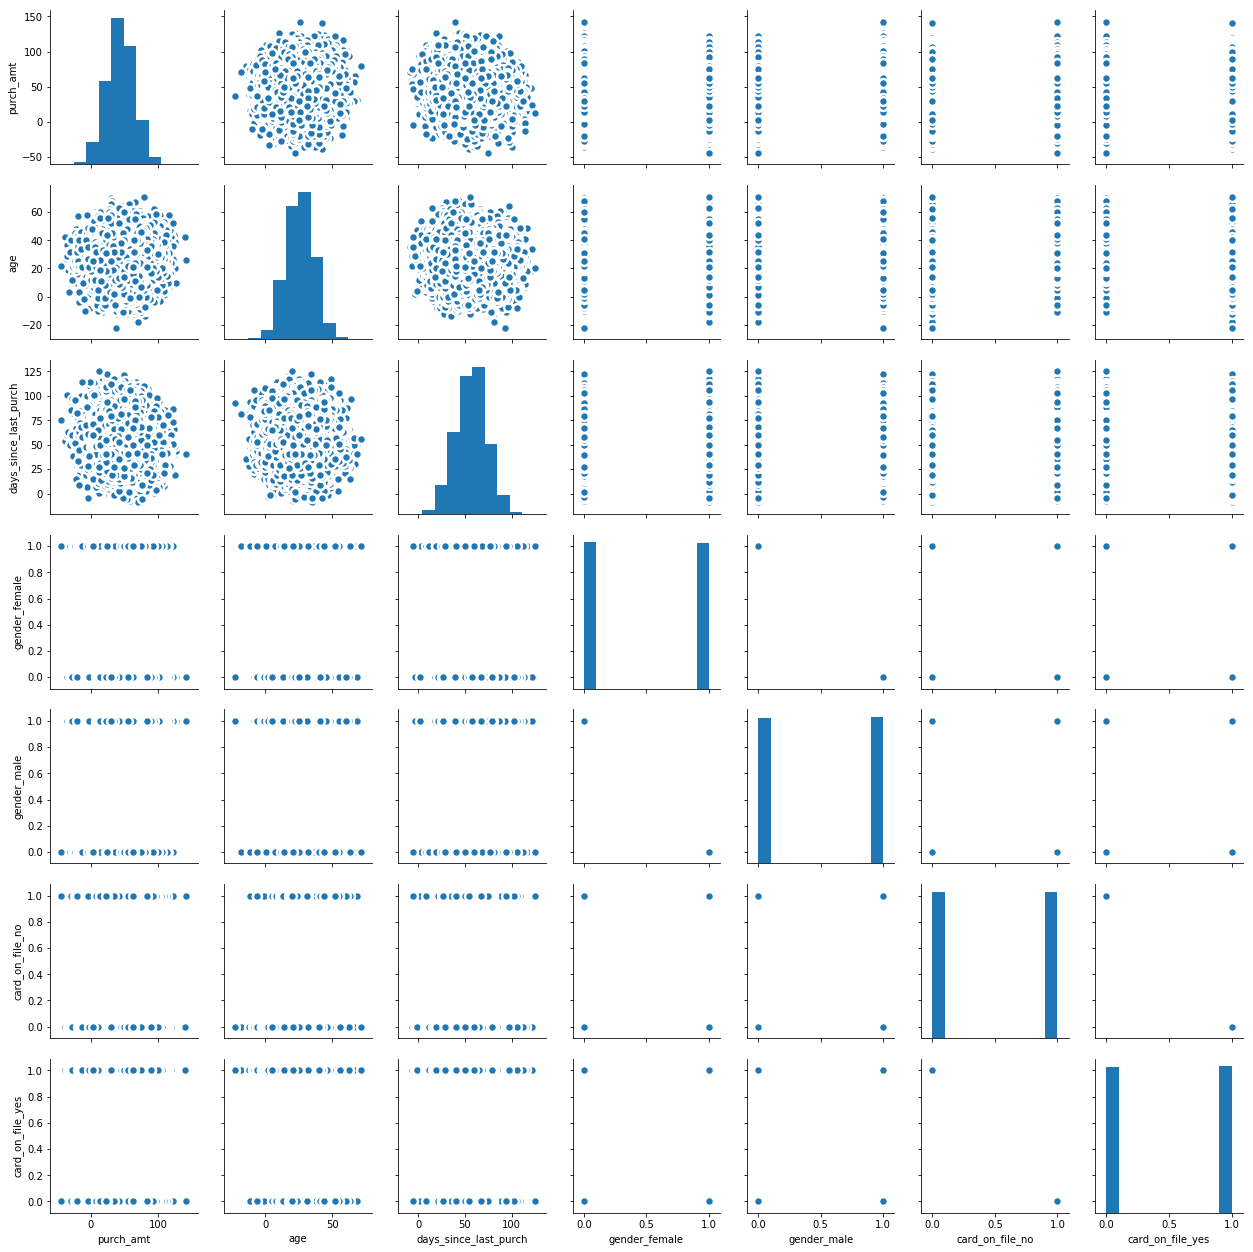

In [6]:
import seaborn as sns
sns.pairplot(df2.drop('loyalty',1), kind='scatter', plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))

In [17]:
df2 = df2.drop(['gender_male', 'card_on_file_yes'],1)
df2.head()

,purch_amt,age,days_since_last_purch,loyalty,gender_female,card_on_file_no
0,19.58,31.0,35.0,False,0,1
1,65.16,23.0,61.0,False,0,0
2,40.60,36.0,49.0,False,1,1
3,38.01,47.0,57.0,False,0,0
4,22.32,5.0,39.0,False,1,0


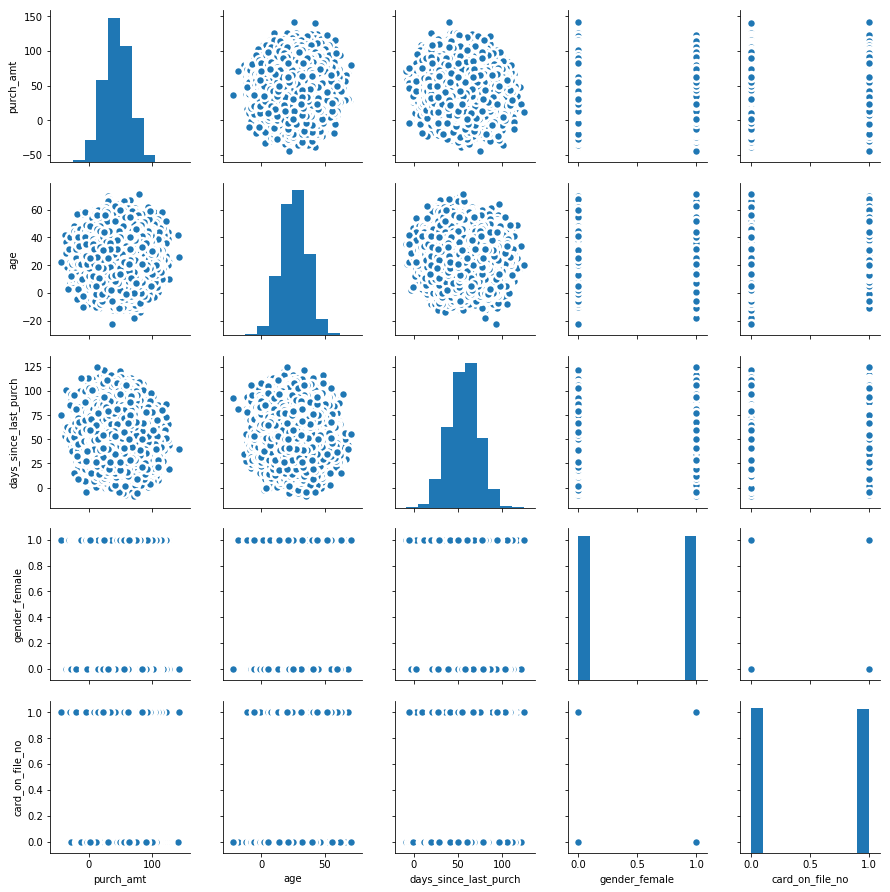

In [8]:
#There three input variables left after droping some for multicollinearity issue
#no multicollinearity observered
sns.pairplot(df2.drop('loyalty',1), kind='scatter', plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))

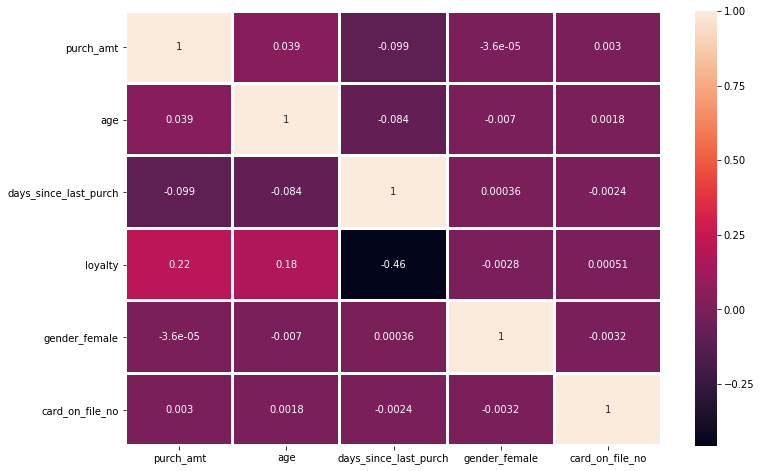

In [20]:
#sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12,8))
#no high correlation between input varialbes
df2_corr = df2.corr()
ax = sns.heatmap(df2_corr.drop('loyalty', 1), linewidth=2,annot=True)
plt.show()

False    100000
True      20000
Name: loyalty, dtype: int64


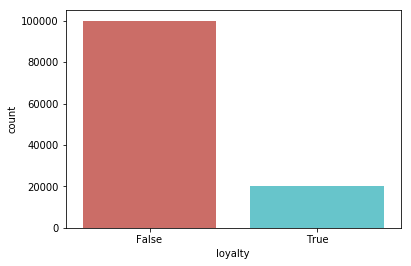

In [21]:
#The data contains unequal number of points for two outcomes
#This could lead to bias so we need to under or over sample it
import seaborn as sns
print(df['loyalty'].value_counts())
sns.countplot(x='loyalty', data=df, palette='hls')

In [22]:
#split the data in to test and train and over and under sample on the train data set
from sklearn.model_selection import train_test_split
train, test = train_test_split(df2, test_size=0.2)
datanumb = train['loyalty'].value_counts()
datanumb

False    80041
True     15959
Name: loyalty, dtype: int64

In [23]:
#In the test data set there are far more 'False' than are 'True'
test['loyalty'].value_counts()

False    19959
True      4041
Name: loyalty, dtype: int64

In [24]:
#Oversampling
train_oversample = train[train['loyalty'] == True].sample(n=datanumb[0], replace=True)
train_false_value = train[train['loyalty'] == False]
#randomize the samples
train_oversample = pd.concat([train_oversample, train_false_value], ignore_index=True).sample(frac=1.0)
print(train_oversample['loyalty'].value_counts())
train_oversample.head()

True     80041
False    80041
Name: loyalty, dtype: int64


,purch_amt,age,days_since_last_purch,loyalty,gender_female,card_on_file_no
112260,30.31,35.0,60.0,False,0,1
7405,79.13,43.0,33.0,True,1,0
63923,78.59,24.0,23.0,True,0,0
126029,74.09,23.0,41.0,False,1,1
142501,19.28,11.0,65.0,False,0,0


In [25]:
#Optimization using gridsearch on the over sampled data

classsifier = LogisticRegression()

gridparam = {'C': [0.0001, 0.001, 0.1, 1, 10, 100],
             'penalty': ['l2'],
             'solver': ['newton-cg','sag', 'saga', 'lbfgs'],
             'max_iter': [500],
            'n_jobs': [4]
            }

logit_model_over = GridSearchCV(classsifier, param_grid=gridparam, cv=5)
logit_model_over.fit(train_oversample.drop('loyalty', 1), train_oversample['loyalty'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], 'max_iter': [500], 'n_jobs': [4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
from sklearn.model_selection import cross_val_score
clf = logit_model_over.best_estimator_
cross_val_score(clf, test.drop('loyalty', 1), test['loyalty'], cv=5)

array([0.86773589, 0.86291667, 0.87541667, 0.86604167, 0.87268181])

In [27]:
clf

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn', n_jobs=4,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
clf.score(train_oversample.drop('loyalty', 1), train_oversample['loyalty'])

0.7954923101910271

In [29]:
clf.score(test.drop('loyalty', 1), test['loyalty'])

0.7914583333333334

In [30]:
from sklearn.metrics import classification_report
y_over_pred = clf.predict(test.drop('loyalty', 1))
print(classification_report(test['loyalty'], y_over_pred, target_names=['True', 'False']))
pd.crosstab(test['loyalty'], y_over_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

        True       0.95      0.79      0.86     19959
       False       0.44      0.81      0.57      4041

   micro avg       0.79      0.79      0.79     24000
   macro avg       0.70      0.80      0.72     24000
weighted avg       0.87      0.79      0.81     24000



Predicted,False,True,All
True,,,
False,15708,4251,19959
True,754,3287,4041
All,16462,7538,24000


In [31]:
#under sample
train_undersample = train[train['loyalty'] == False].sample(n=datanumb[1], replace=False)
train_True_value = train[train['loyalty'] == True]
#randomize the samples
train_undersample = pd.concat([train_undersample, train_True_value], ignore_index=True).sample(frac=1.0)
print(train_undersample['loyalty'].value_counts())
train_undersample.head()

True     15959
False    15959
Name: loyalty, dtype: int64


,purch_amt,age,days_since_last_purch,loyalty,gender_female,card_on_file_no
25926,23.54,25.0,27.0,True,0,1
1953,38.15,23.0,40.0,False,1,0
13591,56.24,31.0,69.0,False,0,0
3155,52.81,18.0,55.0,False,1,1
30011,43.70,23.0,37.0,True,1,1


In [32]:
#Optimization using gridsearch on the under sampled data
logit_model_under = GridSearchCV(classsifier, param_grid=gridparam, cv=5)
logit_model_under.fit(train_undersample.drop('loyalty', 1), train_undersample['loyalty'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.0001, 0.001, 0.1, 1, 10, 100], 'penalty': ['l2'], 'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'], 'max_iter': [500], 'n_jobs': [4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [33]:
clf2 = logit_model_under.best_estimator_
cross_val_score(clf2, test.drop('loyalty', 1), test['loyalty'], cv=5)

array([0.86731931, 0.86333333, 0.87541667, 0.86625   , 0.87309856])

In [34]:
clf2

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn', n_jobs=4,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [35]:
clf2.score(train_undersample.drop('loyalty', 1), train_undersample['loyalty'])

0.7958205401340936

In [36]:
clf2.score(test.drop('loyalty', 1), test['loyalty'])

0.7925416666666667

In [37]:
y_under_pred = clf2.predict(test.drop('loyalty', 1))
print(classification_report(test['loyalty'], y_under_pred, target_names=['True', 'False']))
pd.crosstab(test['loyalty'], y_under_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

        True       0.95      0.79      0.86     19959
       False       0.44      0.81      0.57      4041

   micro avg       0.79      0.79      0.79     24000
   macro avg       0.70      0.80      0.72     24000
weighted avg       0.87      0.79      0.81     24000



Predicted,False,True,All
True,,,
False,15740,4219,19959
True,760,3281,4041
All,16500,7500,24000


<p style="font-family:Helvetica Neue;font-size:20px">
    The model trained with both under and over-sampled training dataset did not produce overfitting problem, as can be seen from their cross-validation score. The models predicted 'False' and 'True' of the test dataset with almost exactly the same precision, 81% for under and 82% for oversampled datasets. Since our test dataset is not symmetric, f1-score is a better performance indicator than accuracy (79% for dataset), although in this case, they are very similar. I would have tried different models here but did not seem like this data set needed it.
</p>

# Random forest

In [38]:
from sklearn import ensemble
random_forest = ensemble.RandomForestClassifier(n_estimators=100,  oob_score = True)

### Over sample dataset

In [39]:
#is randomforest worth running? yes it is accuracy of 99.99% and out-of-bag score of 94.93
random_forest.fit(train_oversample.drop('loyalty', 1), train_oversample['loyalty'])

acc_random_forest = round(random_forest.score(train_oversample.drop('loyalty', 1), train_oversample['loyalty']) * 100, 2)
print(round(acc_random_forest,2,), "%")
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

99.99 %
oob score: 94.93 %


<p style="font-family:Helvetica Neue;font-size:20px">
    Is randomforest worth running? yes it is accuracy of 99.99% and out-of-bag score of 94.93. Out-of-bag estimate is as accurate as using a test set of the same size as the training set, useful for checking and not wasting resources.
</p>

In [40]:
importances = pd.DataFrame({'feature':train_oversample.drop('loyalty', 1).columns,
                            'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

In [41]:
#'card_on_file_no' and 'gender_female' does not paly an important part in this model
#so I will drop them
importances.head(15)

,importance
feature,
days_since_last_purch,0.437
purch_amt,0.377
age,0.160
gender_female,0.013
card_on_file_no,0.013


In [42]:
#retrain the model with different set of input variables
random_forest = ensemble.RandomForestClassifier(n_estimators=100, oob_score = True)

random_forest.fit(train_oversample.drop(['loyalty', 'card_on_file_no', 'gender_female'], 1), 
                  train_oversample['loyalty'])
acc_random_forest = round(
    random_forest.score(train_oversample.drop(['loyalty', 'card_on_file_no', 'gender_female'], 1), 
    train_oversample['loyalty']) * 100, 2)
print(round(acc_random_forest,2,), "%")

99.96 %


<p style="font-family:Helvetica Neue;font-size:20px">
    The model does just as good as before droping the least important variables, so its safe to drop them.
</p>

In [43]:
rfc = ensemble.RandomForestClassifier( max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

gridparam = { "criterion" : ["gini", "entropy"], 
               "min_samples_leaf" : [1, 10, 25], 
               "min_samples_split" : [2,10], 
               "n_estimators": [100]}


rfc_oversample = GridSearchCV(rfc, param_grid=gridparam, cv=5, n_jobs=-1)
rfc_oversample.fit(train_oversample.drop(['loyalty', 'card_on_file_no', 'gender_female'], 1), 
                   train_oversample['loyalty'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 10, 25], 'min_samples_split': [2, 10], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
rfc_best_oversample = rfc_oversample.best_estimator_
rfc_5valscore = cross_val_score(rfc_best_oversample, 
                                test.drop(['loyalty', 'card_on_file_no', 'gender_female'], 1), 
                                test['loyalty'], cv=5)

In [53]:
print(rfc_5valscore)
print(rfc_5valscore.mean())
print(rfc_5valscore.std())
print(rfc_5valscore.max() -rfc_5valscore.min())

[0.85148927 0.85020833 0.86       0.84875    0.86059596]
0.8542087127785176
0.0050503828754465884
0.011845957491144032


<p style="font-family:Helvetica Neue;font-size:20px">
    Standard devation shows us how acurate our score is and varablity showes us if our model is overfitting. Our score is high with high accurecy plus/minus 0.5% and no over fitting.
</p>

In [59]:
y_rfc_over_pred = rfc_best_oversample.predict(test.drop(['loyalty', 'card_on_file_no', 'gender_female'], 1))
print(classification_report(test['loyalty'], y_rfc_over_pred, target_names=['True', 'False']))
pd.crosstab(test['loyalty'], y_rfc_over_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

        True       0.90      0.89      0.89     19959
       False       0.48      0.50      0.49      4041

   micro avg       0.82      0.82      0.82     24000
   macro avg       0.69      0.69      0.69     24000
weighted avg       0.83      0.82      0.83     24000



Predicted,False,True,All
True,,,
False,17755,2204,19959
True,2031,2010,4041
All,19786,4214,24000


### Under sampled dataset

In [56]:
rfc_undersample = GridSearchCV(rfc, param_grid=gridparam, cv=5, n_jobs=-1)
rfc_undersample.fit(train_undersample.drop(['loyalty', 'card_on_file_no', 'gender_female'], 1), 
                   train_undersample['loyalty'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 10, 25], 'min_samples_split': [2, 10], 'n_estimators': [100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [57]:
rfc_best_undersample = rfc_undersample.best_estimator_
rfc2_5valscore = cross_val_score(rfc_best_undersample, 
                                test.drop(['loyalty', 'card_on_file_no', 'gender_female'], 1), 
                                test['loyalty'], cv=5)

In [58]:
print(rfc2_5valscore)
print(rfc2_5valscore.mean())
print(rfc2_5valscore.std())
print(rfc2_5valscore.max() -rfc_5valscore.min())

[0.86419496 0.86458333 0.87520833 0.86229167 0.87226506]
0.8677086695873266
0.0050687949864839784
0.02645833333333336


In [60]:
y_rfc_under_pred = rfc_best_undersample.predict(test.drop(['loyalty', 'card_on_file_no', 'gender_female'], 1))
print(classification_report(test['loyalty'], y_rfc_under_pred, target_names=['True', 'False']))
pd.crosstab(test['loyalty'], y_rfc_under_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

        True       0.95      0.78      0.86     19959
       False       0.43      0.82      0.56      4041

   micro avg       0.78      0.78      0.78     24000
   macro avg       0.69      0.80      0.71     24000
weighted avg       0.87      0.78      0.81     24000



Predicted,False,True,All
True,,,
False,15500,4459,19959
True,742,3299,4041
All,16242,7758,24000


<p style="font-family:Helvetica Neue;font-size:20px">
The best result is predicted by oversampling dataset at f1-score of 83%, 1% higher than best logistic model. 
In my opinion, this model is sufficiently good predictor which can be enhanced by tuning the broader hyperparameters.
</p>
